# Import

In [48]:
import ray
import pandas as pd
import os
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

from dataclasses import dataclass
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from wordcloud import WordCloud, STOPWORDS

# Config

In [2]:
@dataclass
class Config:
    # ray resources
    cpu_per_worker: int = 1
    gpu_per_worker: int = 0
    num_workers:int = 2

    # data
    data_path:str = os.path.join("..", "datasets", "dataset.csv")
    train_ratio:float = 0.6
    test_ratio:float = 0.2
    val_ratio:float = 0.2

    # reproducibility
    seed:int = 2207888

CFG = Config()
print(CFG)

Config(cpu_per_worker=1, gpu_per_worker=0, num_workers=2, data_path='../datasets/dataset.csv', train_ratio=0.6, test_ratio=0.2, val_ratio=0.2, seed=2207888)


# Reproducibility 

In [3]:
def make_reproducible(seed=220788):
    """Set seeds for reproducibility."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)  # should be equivalent to the 2 lines below
    # eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    # eval("setattr(torch.backends.cudnn, 'benchmark', False)")

In [4]:
make_reproducible(CFG.seed)

# Ray Server

In [5]:
# restart ray server (127.0.0.1:8265)
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-12-15 07:25:48,233	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.0
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [6]:
# list detected resources
ray.cluster_resources()

{'memory': 3291896219.0,
 'node:__internal_head__': 1.0,
 'CPU': 8.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 1645948108.0}

In [7]:
# config actual num workers and their resoruces
num_workers = CFG.num_workers
resources_per_worker = {"CPU": CFG.cpu_per_worker, "GPU": CFG.gpu_per_worker}

# Data

In [8]:
df = pd.read_csv(CFG.data_path)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [9]:
# we're interested in how many time each class occurs (this is multiclass, but not multilabel)
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

<Axes: xlabel='tag'>

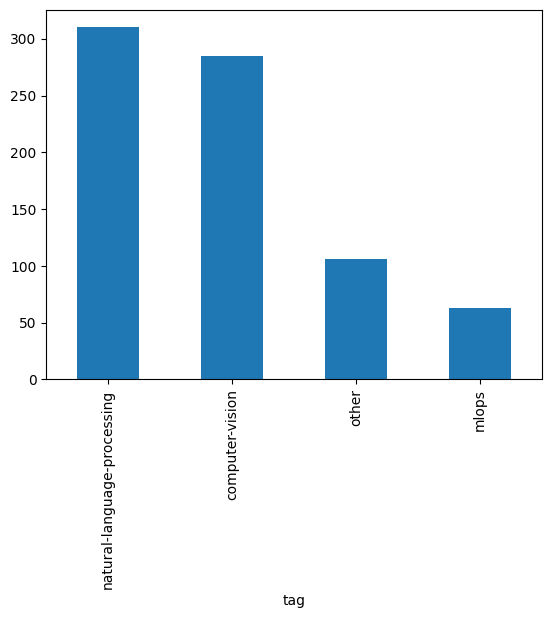

In [10]:
# graph the distribution of classes
df.tag.value_counts().plot.bar()

In [27]:
# split the dataset
train_df, test_and_val_df = train_test_split(df, test_size=1 - CFG.train_ratio, random_state=CFG.seed)
test_df, val_df = train_test_split(test_and_val_df, test_size=CFG.val_ratio / (CFG.test_ratio + CFG.val_ratio), random_state=CFG.seed)

# confirm
print(train_df.shape , test_df.shape, val_df.shape)
print("{:.2f}, {:.2f}, {:.2f}".format(train_df.shape[0] / df.shape[0], test_df.shape[0] / df.shape[0], val_df.shape[0] / df.shape[0]))

(458, 5) (153, 5) (153, 5)
0.60, 0.20, 0.20


In [28]:
# show value counts for new dfs
print(train_df.tag.value_counts())
print(test_df.tag.value_counts())
print(val_df.tag.value_counts())

tag
computer-vision                182
natural-language-processing    178
other                           59
mlops                           39
Name: count, dtype: int64
tag
natural-language-processing    64
computer-vision                48
other                          26
mlops                          15
Name: count, dtype: int64
tag
natural-language-processing    68
computer-vision                55
other                          21
mlops                           9
Name: count, dtype: int64


Proportions are roughly maintained thanks to randomness, I believe.

To preserve class balance via a generator, use `sklearn.model_selection.StratifiedShuffleSplit¶`

# Exploratory Data Analysis
Show the data that we'll be working on.

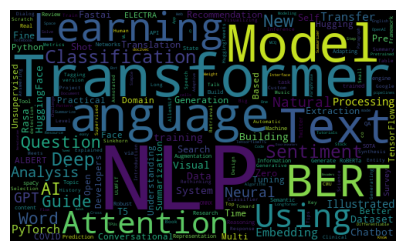

In [49]:

# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)